## Implementation of Quantum Boltzmann Machine

In [1]:

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install qiskit
# !conda install -c weinbe58 omp quspin
# !pip install cffi==1.15

In [2]:
## imports ~~
import numpy as np
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
import math as mt
# from qiskit.quantum_info import Paulia
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from scipy.stats import binom

## StringHandling


In [3]:
## string to vector conversion 
def string_to_vec(binary_string_input):
    '''
    to_return=np.zeros((1,2**(len(binary_string_input))))
    replace_with_one_at=int(binary_string_input,2)
    to_return[0,replace_with_one_at]=1
    '''
    from qiskit.quantum_info import Statevector #string to vector conversion
    to_return=Statevector.from_label(binary_string_input)
    to_return=np.real(to_return)
    #shape of matrix returned= (value,1)
    to_return=np.reshape(to_return,(len(to_return),1))
    return to_return
def vec_to_string(vector_input,dimn_input_tuple):
    '''
    input vector's shape= (num_rows,1)
    '''
    from qiskit.quantum_info import Statevector
    qiskit_statevec=Statevector(vector_input,dims=dimn_input_tuple)
    dict_statevec=list(qiskit_statevec.to_dict().keys())
    string_to_return= dict_statevec[0]
    return string_to_return

## SamplingSubroutines

In [4]:
# sampling subroutines
def prob_distn_of_bitstring_from_model(eigenvector_mat,eigen_vals):
    num_of_qubits=np.log2(len(eigen_vals))
    #print(num_of_qubits)
    
    partn_fn=0; prob_eigenvec=[]
    for i in range(0,len(eigen_vals)):
        exp_val=np.exp(-eigen_vals[i])
        partn_fn+=exp_val
        prob_eigenvec.append(exp_val)#probs are unnormalised till here
    prob_eigenvec=[i/partn_fn for i in prob_eigenvec]
    #print(prob_eigenvec)
    
    
    num_bits_in_string=int(2**(num_of_qubits))
    #print(num_bits_in_string)
    sq_all_elements_eigenvecs=np.square(eigenvector_mat)
    prob_distn_dict={}
    num_eigenvecs=np.shape(eigenvector_mat)[1]
    #print(num_eigenvecs)
    for i in range(0,num_bits_in_string):
        sum_temp=0
        for j in range(0,num_eigenvecs):
            #print((i,j))
            sum_temp+=sq_all_elements_eigenvecs[i,j]*(prob_eigenvec[j])
        string="0"+str(int(num_of_qubits))+"b"
        prob_distn_dict[format(int(i),string)]=sum_temp
    return prob_distn_dict


In [5]:
def generateSamples(num_qubit, numSamples,p):
    '''
    reference: Manuel bhaiya
    '''
    allSamples = []
    for i in range(1):
        data_binom = binom.rvs(n=2**(num_qubit)-1,p=p,loc=0,size=numSamples) #  16 if we use 4 qubits 
        x = []
        for i in data_binom:
            string="0"+str(int(num_qubit))+"b"
            x.append(format(int(i),string))
            #x.append('{0:04b}'.format(i))                       # 6 must be changed to a 4 if the use 4 qubits 
    return x

In [6]:
#############################################################
params = [] 


## OperatorSubroutines

In [7]:
def matrix_tensor_prod_of_operators(string_tensor_prod):
    from qiskit.quantum_info.operators import Pauli
    tensor_prod=Pauli(string_tensor_prod).to_matrix()
    return tensor_prod

#example
print(matrix_tensor_prod_of_operators('ZI'))
print("_"*10)
print(matrix_tensor_prod_of_operators('IZ'))

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]
__________
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


In [8]:
def required_operators(num_qubits,params):
    op_list=[]
    nc2=int(num_qubits*(num_qubits-1))/2
    index=list(range(int(2*num_qubits+nc2)))
    
    #first n: X operators
    #redundant. We won't use this set of operators as h_x's are hyperparas in our model
    for i in range(num_qubits):
        a=["I"]*num_qubits
        a[i]="X"
        to_append="".join(a)
        op_list.append(to_append)
    
    #next n: Z operators
    for i in range(num_qubits):
        a=["I"]*num_qubits
        a[i]="Z"
        to_append="".join(a)
        op_list.append(to_append)
    
    #next nC2: ZiZj operators
    for i in range(0,num_qubits-1):
        a=["I"]*num_qubits
        a[i]="Z"
        for j in range(i+1,num_qubits):
            a[j]="Z"
            to_append="".join(a)
            op_list.append(to_append)
            a[j]="I"
    
    to_return_dict={}
    for i in range(len(op_list)):
        to_return_dict[i]=op_list[i]
    return to_return_dict

def expectation_of_operator(operator_matrix,dict_bitstring_and_prob):
    '''
    Info: This function evaluates expectations like 
         <si_z sj_z>_D, <si_z sj_z>_model
         <si_z sj_z>_D, <si_z sj_z>_model
         (Reference: Manuel bhaiya's thesis pg. 28 eqn no 3.13)
         that are required in gradient descent algorithm
    '''
    
    #inner product
    string_list=list(dict_bitstring_and_prob.keys())
    inner_product_list=[]
    for i in range(len(dict_bitstring_and_prob)):
        vector_of_str=string_to_vec(string_list[i])
        #print(vector_of_str)
        #print("_"*10)
        #print(np.dot(operator_matrix,vector_of_str))
        to_append=np.dot( vector_of_str.T,
                         np.dot(operator_matrix,vector_of_str)
                        )# evaluating <bitstring|Operator|bitstring>
        inner_product_list.append(np.real(to_append)[0][0])
    
    #print("_"*20)
    #print(inner_product_list)

    #calculating <operator>_{some prob distn}= Sumoverj( Prob(j'th bitstring) X <bitstring_j|Operator|bitstring_j> )
    sum_val=0
    for i in range(len(inner_product_list)):
        prob=dict_bitstring_and_prob[ list(dict_bitstring_and_prob.keys())[i] ]
        #print("prob:",prob/sum(list(dict_bitstring_and_prob.values())))
        sum_val+=prob*inner_product_list[i]
        
    return sum_val


### Using BFGS (Broyden-Fletcher-Goldfarb-Shanno) algorithm for training the given model

reference: https://machinelearningmastery.com/bfgs-optimization-in-python/

In [9]:
'''
from scipy.optimize import minimize
from numpy.random import rand

#objective function #cross relative shannon entropy (log likelihood)
def objective():
    pass

#partial derivatives of the objective function (gradient i believe)
def derivatives():#this is where quantum expectation values would go!
    pass

#define range for the input
rmin,rmax=1,2#some values

#define the starting point as a random sample point from the domain
pt = rmin + rand(2) * (rmax - rmin)#would be different in our case

#perform the bfgs algorithm
result_bfgs=minimize(objective,pt,method='BFGS',jac=derivatives)

#summarise the result
print('Status : %s' % result_bfgs['message'])
print('Total Evaluations: %d' % result_bfgs['nfev'])
'''


"\nfrom scipy.optimize import minimize\nfrom numpy.random import rand\n\n#objective function #cross relative shannon entropy (log likelihood)\ndef objective():\n    pass\n\n#partial derivatives of the objective function (gradient i believe)\ndef derivatives():#this is where quantum expectation values would go!\n    pass\n\n#define range for the input\nrmin,rmax=1,2#some values\n\n#define the starting point as a random sample point from the domain\npt = rmin + rand(2) * (rmax - rmin)#would be different in our case\n\n#perform the bfgs algorithm\nresult_bfgs=minimize(objective,pt,method='BFGS',jac=derivatives)\n\n#summarise the result\nprint('Status : %s' % result_bfgs['message'])\nprint('Total Evaluations: %d' % result_bfgs['nfev'])\n"

## UpdationSubroutine

In [10]:
## update 
def update_params(num_qubits, para, dict_rqd_operators, dict_prob_distn_model, dict_prob_distn_data, learning_rate=0.01):
    
    for i in range(num_qubits,len(para)):
        operator_mat = matrix_tensor_prod_of_operators(dict_rqd_operators[i])#getting  required operator matrix
        expectn_op_model = expectation_of_operator(operator_mat,dict_prob_distn_model)
        print("operator Right Now:",dict_rqd_operators[i])
        print("expectation value of operator model:",expectn_op_model)
        expectn_op_data = expectation_of_operator(operator_mat,dict_prob_distn_data)
        update_by = expectn_op_data - expectn_op_model
        print("update by ",i)
        print(update_by)
        para[i] = para[i]+learning_rate*update_by
    
    return para    

In [11]:
from numpy.random import randint,rand
a=rand(2)
print(a)
print(a*10)
print(-5+a*(10))

[0.396602   0.69094854]
[3.96601995 6.90948541]
[-1.03398005  1.90948541]


# K.L. divergence

In [12]:
def kl_divergence(dict_prob_distn_data,dict_prob_distn_model):
    list_prob_model=list(dict_prob_distn_data.values())
    list_prob_data=list(dict_prob_distn_model.values())
    
    to_return=0
    for i in range(0,len(list_prob_model)):
        to_return+=list_prob_data[i]*np.log(list_prob_model[i])
    to_return=(-1)*to_return
    
    return to_return

## Trials

In [13]:
def evals_evec(N,params):
    '''
    Info: function to create hamiltonian  hence evaluate its evals 
    evecs
    '''
    ## initiate parameters
    basis=spin_basis_1d(N,pauli=True) 
    h_x=[[-params[i],i] for i in range(0,N)]
    h_z=[[-params[i],i-N] for i in range(N,2*N)]
    J = params[2*N:]
    J_zz=[]
    counter = 0
    for i in range(0,N-1):
        for j in range(i+1,N):
            J_zz.append([-J[counter],i,j])
            counter += 1

    #########################################################################
    #static and dynamic list
    static=[['zz',J_zz],["x",h_x],["z",h_z]]
    dynamic=[]
    #reference: manuel bhaiya
    no_checks={"check_herm":False,"check_pcon":False,"check_symm":False}
    #defining qbm hamiltonian
    Hamiltonian_qbm=hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
    #print(Hamiltonian_qbm)
    #finding eigenvalues and eigen-vector
    E,V=Hamiltonian_qbm.eigh()

    return E, V


In [14]:
def run(N, params, trainingDict, iterations, learning_rate=0.001, progressbar_params= False, progressbar_dist= False):
    ###############################################################################
    #define training metrics
    operators= required_operators(N, params)
    #print("operators are:")
    #print(operators)
    kldiv_list= []
    param_list= []
    model_dist_dict_list= []
    for iter in range(iterations):
        E,V= evals_evec(N,params)#E: eigen values,V: matrix of eigen vectors
        #eigen vectors are arranged columnwise~
        #########################################################################
        #generate model dist
        model_dist_dict = prob_distn_of_bitstring_from_model(V,E)
        kldiv_list.append(kl_divergence(trainingDict, model_dist_dict))
        model_dist_dict_list.append(model_dist_dict)
        

        #updating parmaters iteratively
        print("going inside update params function")
        params = update_params(N, params, operators,
                             model_dist_dict, trainingDict, 
                             learning_rate=learning_rate)
        param_list.append(params)

        ##broadcast update
        if(progressbar_params== True):
            print("params: ")
            print( params,  end='\n')
        if(progressbar_dist== True):
            print("dist: ")
            print(model_dist_dict, end='\n')
            
        
    return params, kldiv_list, model_dist_dict, 

In [15]:
N=2# number of qubits
numParams = int(2*N + N*(N-1)/2)
numParams

5

In [16]:
#########################################################################
## define model parameters
J=1.0
g=0.809 # transverse field
h=0.9045 # longitudinal field
basis=spin_basis_1d(N,pauli=True)
# params= np.random.rand(numParams)-0.5a #[first N hz| next n:hx | nC2: h1zh2z]
params = [0.5]*numParams # [0,0,1,1,1]
iterations = 1

evals, evec_mat=evals_evec(N,params)
print(evals) ;print(evec_mat)
dict_prob_distn_model=prob_distn_of_bitstring_from_model(evec_mat,evals)
print("probability distn of bitsrings from model")
print(dict_prob_distn_model)

[-1.7469796  -0.05495813  0.5         1.30193774]
[[ 9.39027395e-01 -2.89200275e-01  0.00000000e+00  1.85985892e-01]
 [ 2.31920614e-01  4.17906506e-01 -7.07106781e-01 -5.21120889e-01]
 [ 2.31920614e-01  4.17906506e-01  7.07106781e-01 -5.21120889e-01]
 [ 1.03214383e-01  7.53041503e-01  2.22044605e-16  6.49827120e-01]]
probability distn of bitsrings from model
{'00': 0.6721233413021916, '01': 0.11342597506719237, '10': 0.11342597506719239, '11': 0.10102470856342344}


## generate data distribution

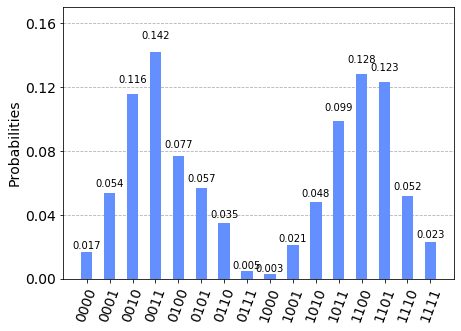

In [17]:
#########################################################################

## reference: Manuel bhaiya
ts = generateSamples(4,500,0.8)             ## this one is on the left of the tomo
temp = np.unique(ts,return_counts=True)
TS = {temp[0][i]:temp[1][i] for i in range(len(temp[0]))}
ps = generateSamples(4,500,0.2)             ## this on is in the middle of the tomo
pemp = np.unique(ps,return_counts=True)
PS = {pemp[0][i]:pemp[1][i] for i in range(len(pemp[0]))}

both = list(np.append(ts,ps))          ## this one has both
stemp = np.unique(both,return_counts=True)
trainingDict = {stemp[0][i]:stemp[1][i] for i in range(len(stemp[0]))} 
plot_histogram(trainingDict)



# run Quantum Boltzmann Machine

initial parameters: 
[50, 50, 50, 50, 0.2570780516740194, 0.12019730142088547, -0.28474307549054045, -0.39575234794710856, 0.13804620266206724, 0.36161845453944663, -0.20551342445984533, 0.3161682411505645, -0.07016708509581793, 0.14612715854659208]
going inside update params function
operator Right Now: ZIII
expectation value of operator model: 0.0051395797988038755
update by  4
5.994860420201196
operator Right Now: IZII
expectation value of operator model: 0.0023933948399218613
update by  5
-0.0023933948399218613
operator Right Now: IIZI
expectation value of operator model: -0.005665358127198594
update by  6
-39.994334641872804
operator Right Now: IIIZ
expectation value of operator model: -0.00795570086744931
update by  7
-47.99204429913255
operator Right Now: ZZII
expectation value of operator model: 0.0014120035397558323
update by  8
309.99858799646023
operator Right Now: ZIZI
expectation value of operator model: 0.0035888608910284725
update by  9
-146.00358886089103
operator Right

/home/rajarsi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/home/rajarsi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


going inside update params function
operator Right Now: ZIII
expectation value of operator model: nan
update by  4
nan
operator Right Now: IZII
expectation value of operator model: nan
update by  5
nan
operator Right Now: IIZI
expectation value of operator model: nan
update by  6
nan
operator Right Now: IIIZ
expectation value of operator model: nan
update by  7
nan
operator Right Now: ZZII
expectation value of operator model: nan
update by  8
nan
operator Right Now: ZIZI
expectation value of operator model: nan
update by  9
nan
operator Right Now: ZIIZ
expectation value of operator model: nan
update by  10
nan
operator Right Now: IZZI
expectation value of operator model: nan
update by  11
nan
operator Right Now: IZIZ
expectation value of operator model: nan
update by  12
nan
operator Right Now: IIZZ
expectation value of operator model: nan
update by  13
nan
going inside update params function
operator Right Now: ZIII
expectation value of operator model: -4.996003610813204e-16
update by

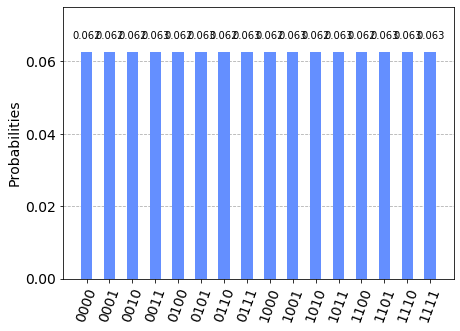

<Figure size 432x288 with 0 Axes>

In [21]:
#########################################################################
## define model parameters
N=4# number of qubits
numParams = int(2*N + N*(N-1)/2)

J=1.0
g=0.809 # transverse field
h=0.9045 # longitudinal field
basis=spin_basis_1d(N,pauli=True)
# for the time being we're interested in diagonal hamiltonian
params= [50]*N + list(np.random.rand(numParams-N)-0.5) #[first N hx| next n:hz | next nC2: h1zh2z]
# params = [0,0,0,0,0]
iterations = 100
print("initial parameters: ");print(params)

p, kl, model_dist = run(N, params, trainingDict,
                        iterations, learning_rate=0.01, progressbar_dist=False, progressbar_params=False)
plt.figure(1)
plot_histogram(model_dist)


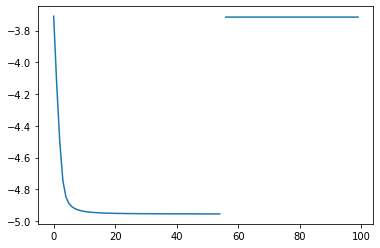

In [19]:
plt.plot(kl)

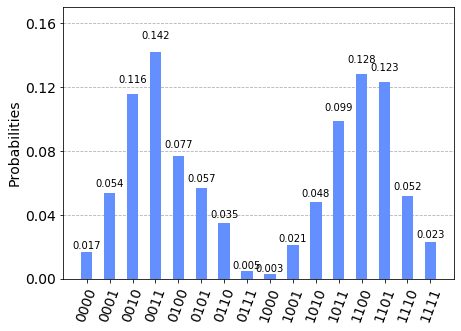

In [20]:
plot_histogram(trainingDict)
# print(p)